In [148]:
from google.colab import drive, files
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re, string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords


from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.models import *
from keras.optimizers import Adam

In [ ]:
# ! pip install -q kaggle
# !mkdir covid_tweet
# !cp kaggle.json ~/.kaggle
# !kaggle datasets download -d datatattle/covid-19-nlp-text-classification

In [3]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Kaggle/covid_tweet')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("Corona_NLP_train.csv", engine='python')

In [ ]:
df_train = pd.read_csv("Corona_NLP_train.csv",  engine='python')
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
df_train.OriginalTweet.loc[0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

# Data Cleaning

In [ ]:
nltk.download('stopwords')

def clean_text(text):
    '''Make text lowercase then remove punctuation, username, and links'''
    text = text.lower()
    text = re.sub('@\S*|http\S*', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s\s+', ' ', text)

    new_text = [x for x in text.split(' ') if x not in stopwords.words()]
    new_text = ' '.join(new_text)
    return new_text

ct = lambda x: clean_text(x)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [565]:
#This process took ~2 hours, load the cleaned data to proceed

# df_train.OriginalTweet = df_train.OriginalTweet.apply(ct)

# Data Preparation

In [539]:
df_train = pd.read_csv("df_train_cleaned")

In [540]:
df_train = df_train[(df_train.OriginalTweet.isna() == False) & (df_train.Sentiment.isna() == False)]

In [541]:
encode = {"Extremely Negative":-1, "Negative":-1, "Neutral":0, "Positive":1, "Extremely Positive":1}
df_train.Sentiment = df_train.Sentiment.map(encode)

In [542]:
X_train = df_train.OriginalTweet.values
y_train = df_train.Sentiment

In [516]:
#Undersampling, 60% val_acc

# new_X_train = []
# new_y_train = []

# neg = 0
# neu = 0
# pos = 0 
# limit = y_train.value_counts().min()
# y_train = y_train.values
# for idx in range(len(y_train)):
#   if y_train[idx] == -1:
#     if neg < limit:
#       new_X_train.append(X_train[idx])
#       new_y_train.append(-1)
#       neg += 1
#   elif y_train[idx] == 0:
#     if neu < limit:
#       new_X_train.append(X_train[idx])
#       new_y_train.append(0)
#       neu += 1
      
#   else:
#     if pos < limit:
#       new_X_train.append(X_train[idx])
#       new_y_train.append(1)
#       pos += 1


# X_train = new_X_train
# y_train = new_y_train
# print(len(new_X_train))


23034


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


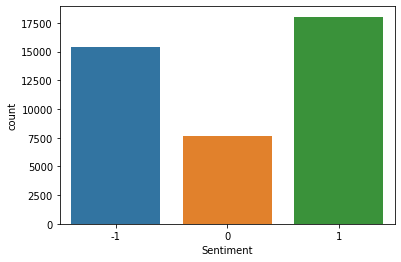

In [545]:
sns.countplot(y_train)

**Tokenization**

In [548]:
tokenizer = Tokenizer(oov_token='-')
tokenizer.fit_on_texts(X_train)

In [549]:
vocab_length = len(tokenizer.word_index) + 1
embedding_dim = 64
max_len = 32

In [550]:
X_train = tokenizer.texts_to_sequences(X_train)

In [551]:
 X_train = pad_sequences(X_train,
                        padding = 'post',
                        maxlen = max_len,
                        truncating = 'post')

In [501]:
# Oversampling data with SMOTE, but 40% val_acc

# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [566]:
# Convert the label to categorical array

y_train = tf.keras.utils.to_categorical(y_train, 3)

In [555]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 48736
Max sequence length: 32


**Modelling**

In [557]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [529]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])
# # opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [558]:
#make folder model
model._name = "Covid_Sentiment_LSTM_undersampling"
model_save_path = "./models/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [559]:
model.summary()

Model: "Covid_Sentiment_LSTM_undersampling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 32, 64)            3119104   
_________________________________________________________________
lstm_35 (LSTM)               (None, 512)               1181696   
_________________________________________________________________
dense_96 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_97 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_98 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_99 (Dense)             (None, 3)                 99        
Total params: 4,469,251
Trainable params: 4,469,251
Non-trainable params: 0
______________________

In [560]:
#Terminates training when vall_acc > 90%
class TerminateOnBaseline(Callback):
    """Callback that terminates training when val_acc reaches a specified baseline
    """
    def __init__(self, monitor='val_accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [561]:
#Callbacks

checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
# early_stop = EarlyStopping(patience=7, verbose=1, monitor='val_accuracy', mode='max')

In [562]:
#Training

num_epochs = 10
history = model.fit(X_train, 
                    y_train, 
                    epochs=num_epochs,
                    steps_per_epoch = len(X_train)//128,
                    validation_split=0.2, 
                    verbose=1,
                    callbacks=[checkpoint, TerminateOnBaseline()])

Epoch 1/10
321/321 [==============================] - 286s 886ms/step - loss: 0.9265 - accuracy: 0.5148 - val_loss: 0.7447 - val_accuracy: 0.6960

Epoch 00001: val_accuracy improved from -inf to 0.69597, saving model to ./models/Covid_Sentiment_LSTM_undersampling.h5
Epoch 2/10
321/321 [==============================] - 285s 887ms/step - loss: 0.5195 - accuracy: 0.8088 - val_loss: 0.5641 - val_accuracy: 0.7975

Epoch 00002: val_accuracy improved from 0.69597 to 0.79752, saving model to ./models/Covid_Sentiment_LSTM_undersampling.h5
Epoch 3/10
321/321 [==============================] - 283s 881ms/step - loss: 0.3023 - accuracy: 0.9040 - val_loss: 0.5693 - val_accuracy: 0.8125

Epoch 00003: val_accuracy improved from 0.79752 to 0.81248, saving model to ./models/Covid_Sentiment_LSTM_undersampling.h5
Epoch 4/10
321/321 [==============================] - 282s 878ms/step - loss: 0.2039 - accuracy: 0.9386 - val_loss: 0.7317 - val_accuracy: 0.8012

Epoch 00004: val_accuracy did not improve from

**Plotting Training Result**

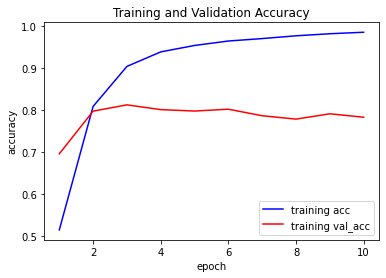

In [563]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training acc")
plt.plot(epochs, val_acc, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

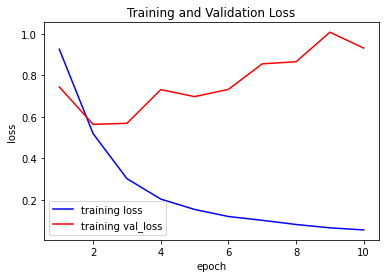

In [564]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()